In [3]:
import pandas as pd
import imageio
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from imageio import imread
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from skimage import feature

# Tactical and match information extraction through football matches frames

## Abstract

Nowadays, football tactics are developed with sofisticated and innovative techniques more often. Alongside with this scenario, there are several ways to reach out better results on the pitch for a professional team: improve physical tests, study opponents in-match patterns, review mistakes and flaws from past fixtures, amongst many other activities. The technological enhancements in these tasks are currently being led by integrating a different knowledge area: data analysis. This project has the main goal of exploring image datasets composed by match situations frames, provided by an open-source dataset [1], and extract key indicators from the match events displayed about the tactical disposition of the teams. The main metric that should be obtained is the amount of players of each team in the analyzed image.

## Methodology

The desired method to extract valuable information from football matches frames involves the use of in-match events frames preprocessed. Then, it will be applied in the selected images the bag of features to describe tactical information about the game scenario. The main goal of the image processing is to obtain the amount of players of each team in certain frame of the match. This description could lead to a rich analysis when enriching the data with more match events such as score and minutes played to analyze how the team behaved in that certain momentum of the competition.

### Dataset

The dataset selected for this project is a fragment of the dataset made available by [1]. The original dataset contains several images of in-match events taken from frames of TV transmission of the fixtures. The situations portrayed as samples can be several: free-kick angle, card showed by refferee to a player, goal celebrations, amongst many others.

This study has interest only in wide pictures of players distributed through the pitch. Due to that, the complete dataset of the study were refined to mantain only images where tactical information could be potentially extracted, i.e., the dataset used has only images of wide range taken when the ball was inside the pitch and a significant amount of players is shown.

An example below will show the common behavior in the dataset images.

In [5]:
input_image = imageio.imread('./IAUSD Dataset/20.jpg') 

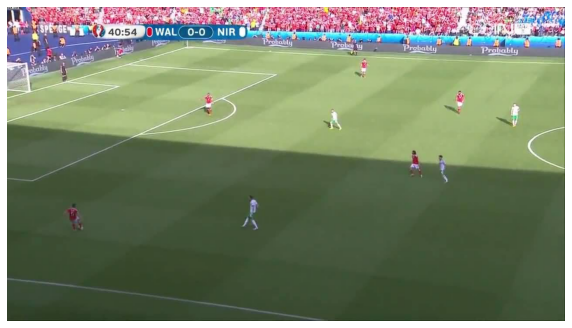

In [6]:
# plot of original image
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(input_image)

The approach of understanding the correct analysis of the frame involves previous knowledge about the samples selected. Below, there is a list of expected answers for each image of the small dataset of 50 inputs:
* 20.jpg - Team A: 5 players; Team B: 4 players
* 127.jpg - Team A: 6 players; Team B: 9 players
* 219.jpg - Team A: 8 players; Team B: 7 players
* 224.jpg - Team A: 8 players; Team B: 5 players
* 239.jpg - Team A: 5 players; Team B: 5 players
* 244.jpg - Team A: 7 players; Team B: 7 players
* 1021.jpg - Team A: 8 players; Team B: 6 players
* 1022.jpg - Team A: 8 players; Team B: 6 players
* 1025.jpg - Team A: 7 players; Team B: 7 players
* 1028.jpg - Team A: 5 to 6 players; Team B: 8 players
* 1045.jpg - Team A: 1 player; Team B: 3 players
* 1065.jpg - Team A: 8 players; Team B: 7 players
* 1082.jpg - Team A: 2 players; Team B: 3 players
* 1190.jpg - Team A: 6 players; Team B: 8 players
* 1223.jpg - Team A: 6 players; Team B: 3 players
* 1283.jpg - Team A: 6 to 7 players; Team B: 4 players
* 1304.jpg - Team A: 8 players; Team B: 7 players
* 1307.jpg - Team A: 6 players; Team B: 9 players
* 1362.jpg - Team A: 9 to 10 players; Team B: 10 players
* 1369.jpg - Team A: 8 to 9 players; Team B: 9 to 10 players
* 1384.jpg - Team A: 8 to 9 players; Team B: 7 to 8 players
* 1437.jpg - Team A: 7 players; Team B: 5 players
* 1533.jpg - Team A: 8 players; Team B: 6 players
* 1564.jpg - Team A: 6 to 7 players; Team B: 7 players
* 1602.jpg - Team A: 6 to 7 players; Team B: 8 players
* 1662.jpg - Team A: 4 players; Team B: 7 players
* 1683.jpg - Team A: 5 players; Team B: 9 players
* 1711.jpg - Team A: 7 players; Team B: 6 to 7 players
* 1719.jpg - Team A: 7 players; Team B: 6 to 7 players
* 1753.jpg - Team A: 7 players; Team B: 5 players
* 1756.jpg - Team A: 9 players; Team B: 7 players
* 1769.jpg - Team A: 5 players; Team B: 7 players
* 1796.jpg - Team A: 10 players; Team B: 9 players
* 1802.jpg - Team A: 6 to 7 players; Team B: 7 players
* 1850.jpg - Team A: 5 players; Team B: 6 players
* 1915.jpg - Team A: 7 players; Team B: 7 players
* 1937.jpg - Team A: 6 players; Team B: 7 to 8 players
* 1955.jpg - Team A: 8 players; Team B: 6 players
* 1966.jpg - Team A: 5 to 6 players; Team B: 7 players
* 1969.jpg - Team A: 3 to 5 players; Team B: 7 players
* 1981.jpg - Team A: 7 players; Team B: 7 to 8 players
* 2011.jpg - Team A: 2 to 4 players; Team B: 7 players
* 2021.jpg - Team A: 6 players; Team B: 7 players
* 2055.jpg - Team A: 8 to 9 players; Team B: 6 players
* 10321.jpg - Team A: 7 to 8 players; Team B: 10 players
* 14775.jpg - Team A: 8 players; Team B: 6 players
* 16678.jpg - Team A: 5 players; Team B: 5 to 6 players
* 18566.jpg - Team A: 10 players; Team B: 7 players
* 23269.jpg - Team A: 9 players; Team B: 6 players
* 24531.jpg - Team A: 3 players; Team B: 6 to 7 players

Inconclusive player counts (x to y players) rely on the situations were the frame could lead just to part of the body of the player, turning the definition of the presence of a player unstable to check.

As long as the analysis will also use color to distinguish the teams, the goalkeeper will be excluded from the count of the players. Team A and Tema B could vary in the output, according to the order of analysis, as long as attack and defense conditions are not defined.

### Preprocessing

A few techniques will be applied on the images for better understanding of the behavior of the descriptors that wiil be applied to get information about the amount of players displayed on the pitch. The path to be followed will rely in some tests:
* Debluring, if necessary;
* Conversion of RGB into only one of the channels: 
 * One of the colors (red, green or blue);
 * Greyscale image through luminance.


The first approach beneath the cited above will be prioritized in the study. The image above will be used as the example to go through the preproceesing step.

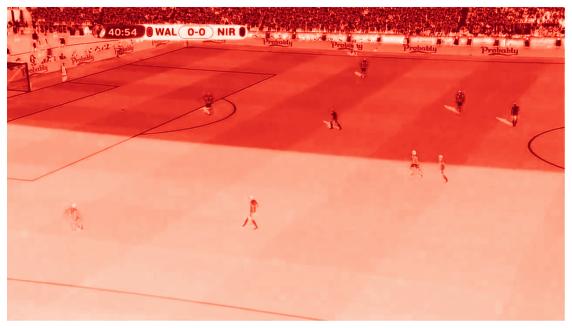

In [12]:
# one channel preprocessing - red

input_image_R = input_image[:,:,0].astype(float)
input_image_R = input_image_R.astype(np.uint8)



# plot of converted image
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(input_image_R, cmap='Reds')

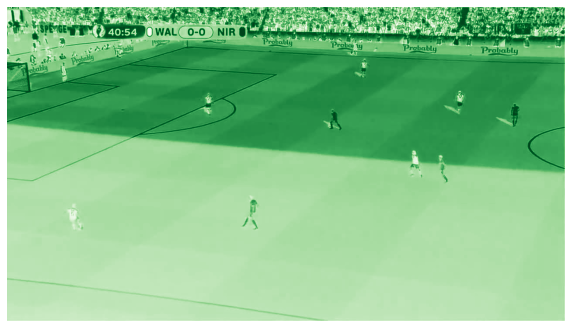

In [16]:
# one channel preprocessing - green

input_image_G = input_image[:,:,1].astype(float)
input_image_G = input_image_G.astype(np.uint8)


# plot of converted image
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(input_image_G, cmap='Greens')

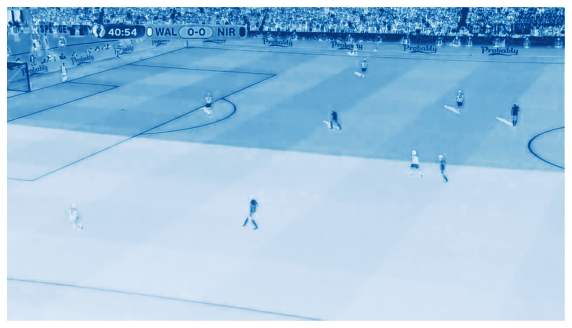

In [18]:
# one channel preprocessing - blue

input_image_B = input_image[:,:,2].astype(float)
input_image_B = input_image_B.astype(np.uint8)


# plot of converted image
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(input_image_B, cmap='Blues')

Only in this example of the dataset, it is noticed that shadow can interfere in the player detection and could not be that effective to separate players of diffrent teams.

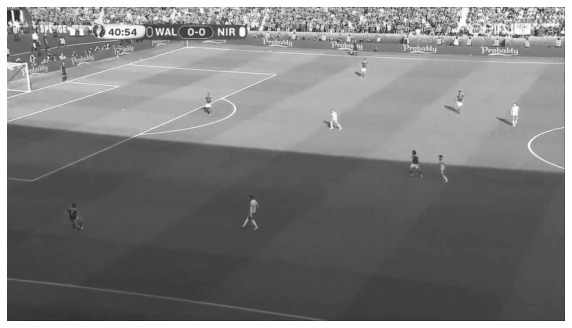

In [19]:
# greyscale preprocessing through luminance method

input_image_luminance = input_image.astype(float)
input_image_luminance = input_image_luminance[:,:,0]*0.3 + input_image_luminance[:,:,1]*0.59 + input_image_luminance[:,:,2]*0.11
input_image_luminance = input_image_luminance.astype(np.uint8)

# normalization
img_min = np.min(input_image_luminance)
img_max = np.max(input_image_luminance)
if (img_max - img_min != 0):
    input_image_luminance = (input_image_luminance - img_min)/(img_max-img_min)
    
# result
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(input_image_luminance, cmap = plt.get_cmap(name = 'gray'))

As long as the intention of the project is to check how many players are displayed in pitch and their separation between two teams, in the space domain, the conversion to greyscale, visually, has shown itself more effective to achieve these objectives.

### Bounding Boxes and Bag of Features

With the preprocessed images, it is possible to start the actual process of information extraction. The techniques applied imply in branching the image in several rectangular sections, that could isolate a piece of the frame that could contain a player. Being able to find out wether or not there is a valuable information in that section, the algorithm of the bag of features will be applied with the strategy of extracting this answer from the original image through the descriptors.

The division strategy is to fit a player into the "texton". By this, patches would be 96x48, representing a rectangular shape that must contain the player. With this configuration, it must have a total of almost 190 patches in the input image. That frame size could vary depending on the image size.

(-0.5, 47.5, 95.5, -0.5)

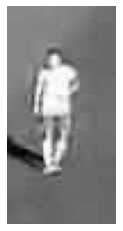

In [64]:
# separating image parts
patches = extract_patches_2d(input_image_luminance, 
                           patch_size=(96,48),
                           max_patches=190, 
                           random_state=0)

# example of patch generated
plt.imshow(patches[81], cmap = plt.get_cmap(name = 'gray'))
plt.axis('off')

By this example of patch, it is possible to refine and find specific framing to get a player as one of the image descriptors. After creating the sections, the bag of features will be apllied.

The first step of the bag of features is to create a method to obtain features from the patches generated. It will be used the LBP (Local Binary Patterns) method due to the greylevel contrast between player borders and the pitch, with unstable behavior when the background is not necessarily the grass (it could be advertising banners, the crowd or the goal post).

The LBP will be set with a bigger radius and high sampling points for the alogrithm to be able to detect the player in any possible aspect inside the patch (centered or not, for example).

In [97]:
def lbp_features(img, radius, sampling_pixels):
    
    lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))

    hist = hist.astype("float")
    hist = hist/(hist.sum() + 1e-6)
    return hist

In [98]:
# obtaining features lbp for each patch
patch_lbp = []
for pat in patches:
        f = lbp_features(pat,4,16)
        patch_lbp.append(f)

patch_lbp = np.array(patch_lbp)
print('Created LBP feature spaces')
print('Patches = ', len(patch_lbp), ' size = ', patch_lbp[0].shape[0])

Created LBP feature spaces
Patches =  190  size =  18


The next step is the definition of the dictionary of "visual words". By this a clustering algorithm is applied to create this dictionary.

(-0.003743489582520944,
 0.07861328123293981,
 -0.0037760416658472132,
 0.07929687498279148)

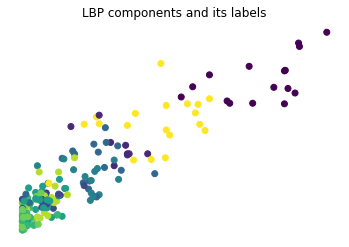

In [99]:
kmeans_model = KMeans(n_clusters=10, 
                      verbose=False, 
                      init='random',
                      random_state=1)

kmeans_model.fit(patch_lbp)
plt.scatter(patch_lbp[:, 0], patch_lbp[:, 1], c=kmeans_model.labels_)
plt.title('LBP components and its labels')
plt.axis('off')

In the example above, we could reach how the clustering performed in a single image. In order to perform the bag of features, the group of images of the dataset will be used and split into training and test sets, in a 70/30 proportion, respectively.

In [110]:
#training set
path = './IAUSD Dataset/'
imgs = listdir(path)
train_set = imgs[0:35]
test_set = imgs[35:-1]

# patches definition
patch_arr = []

for img in train_set:
    input_image = imageio.imread(path+img) 
    input_image_luminance = input_image.astype(float)
    input_image_luminance = input_image_luminance[:,:,0]*0.3 + input_image_luminance[:,:,1]*0.59 + input_image_luminance[:,:,2]*0.11
    input_image_luminance = input_image_luminance.astype(np.uint8)

    # normalization
    img_min = np.min(input_image_luminance)
    img_max = np.max(input_image_luminance)
    if (img_max - img_min != 0):
        input_image_luminance = (input_image_luminance - img_min)/(img_max-img_min)
    
    patch_arr.append(extract_patches_2d(input_image_luminance, 
                           patch_size=(96,48),
                           max_patches=190, 
                           random_state=0))

patch_arr = np.array(patch_arr)

In [125]:
#test set
# patches definition
patch_arr_test = []

for img in test_set:
    input_image = imageio.imread(path+img) 
    input_image_luminance = input_image.astype(float)
    input_image_luminance = input_image_luminance[:,:,0]*0.3 + input_image_luminance[:,:,1]*0.59 + input_image_luminance[:,:,2]*0.11
    input_image_luminance = input_image_luminance.astype(np.uint8)
    
    # normalization
    img_min = np.min(input_image_luminance)
    img_max = np.max(input_image_luminance)
    if (img_max - img_min != 0):
        input_image_luminance = (input_image_luminance - img_min)/(img_max-img_min)
    
    patch_arr_test.append(extract_patches_2d(input_image_luminance, 
                           patch_size=(96,48),
                           max_patches=190, 
                           random_state=0))

patch_arr_test = np.array(patch_arr_test)

In [120]:
# obtaining features lbp for each patch


patch_lbp = []
for image in patch_arr:
    for patch in image:
        f = lbp_features(patch,4,16)
        patch_lbp.append(f)

patch_lbp = np.array(patch_lbp, copy=False)
print('Instances = ', len(patch_lbp), ' size = ', patch_lbp[0].shape[0])
print('Created LBP feature spaces')
print('\tpatches = ', len(patch_lbp), ' size = ', patch_lbp[0].shape[0])

Instances =  6650  size =  18
Created LBP feature spaces
	patches =  6650  size =  18


In [116]:
# KMeans application in "train" set.
kmeans_model = KMeans(n_clusters=10, 
                      verbose=False, 
                      init='random',
                      random_state=1)

kmeans_model.fit(patch_lbp)

KMeans(init='random', n_clusters=10, random_state=1, verbose=False)

(-0.005219184026645143,
 0.10960286455954799,
 -0.004720052082309016,
 0.09912109372848935)

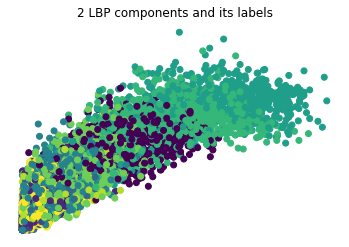

In [117]:
plt.scatter(patch_lbp[:, 0], patch_lbp[:, 1], c=kmeans_model.labels_)
plt.title('2 LBP components and its labels')
plt.axis('off')

Through the clustering, it is possible to infer in which of them, the players are the information obtained.

In [126]:
# obtaining features lbp for each patch in test set


patch_lbp_test = []
for image in patch_arr_test:
    for patch in image:
        f = lbp_features(patch,4,16)
        patch_lbp_test.append(f)

patch_lbp_test = np.array(patch_lbp_test, copy=False)
print('Instances = ', len(patch_lbp_test), ' size = ', patch_lbp_test[0].shape[0])
print('Created LBP feature spaces')
print('\tpatches = ', len(patch_lbp_test), ' size = ', patch_lbp_test[0].shape[0])

Instances =  2660  size =  18
Created LBP feature spaces
	patches =  2660  size =  18


In [136]:
# computing features of train set

img_feats = []
n_patches = 190
for i in range(len(train_set)):
    y = kmeans_model.predict(patch_lbp[i*n_patches: (i*n_patches)+n_patches])

    # computes histogram and append in the array
    hist_bof,_ = np.histogram(y, bins=range(10+1), density=True)
    img_feats.append(hist_bof)

img_feats = np.array(img_feats)

In [147]:
# computing features of test set

img_feats_test = []
n_patches = 190
for i in range(len(test_set)):
    y = kmeans_model.predict(patch_lbp_test[i*n_patches: (i*n_patches)+n_patches])

    # computes histogram and append in the array
    hist_bof,_ = np.histogram(y, bins=range(10+1), density=True)
    img_feats_test.append(hist_bof)

img_feats_test = np.array(img_feats_test)

As a final step the results of the clustering process are checked in "test" set.

In [148]:
# distances between samples of each set
dists = []
for i in range(len(test_set)):
    diq = np.sqrt(np.sum((img_feats_test[i]-img_feats)**2))
    dists.append(diq)

# check the nearest images
k = 5
k_cbir = np.argsort(dists)[:k]

k_cbir

array([12,  0,  2,  6, 10])

### Desired Results

The results desired after the applying of the algorithms of the methodology is the information extraction from the match frame. The main metric to be obtained is the number of players of each team displayed in that fragment of the pitch, additional information important to be computed in case of successful approach is the attack/defence scenario description. 

### Actual Results

Bag of features were helpful, at the end of the day to check similarities. In a situation where part of the dataset has information already defined by the tactics, the train images could be used to check, through similarity, which one of them represents the most the sample in test set in order to check the amount of players displayed in the pitch. In other words, same tactics should have more similarity in the application of the bag of words. 

### Analysis of Results

Some of the results displayed will be drilled down for better unederstanding of the actual performance of the image processing proposed.

The example that will proceed will be to check if certain test image will have a better similarity with images fo train set that have the same amount of players in the pitch.

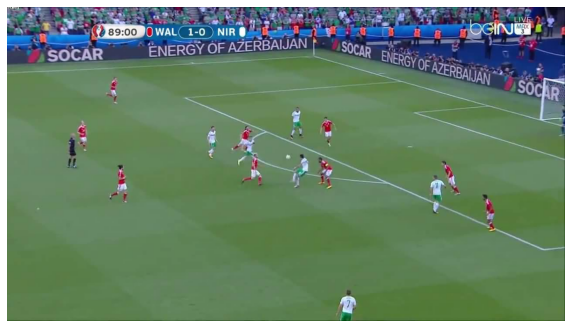

In [144]:
test_picked_image = imageio.imread('./IAUSD Dataset/1683.jpg') 
# plot of original image
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(test_picked_image)

As seen above, this image from test set has 14 players on the pitch, not including goalkeeper. The idea is to reach it as one of the most similar images of the test set to the selected train test images, which have 14 players as well. 

In [146]:
#training set
path = './IAUSD Dataset/'
train_set = ['1025.jpg', '1190.jpg', '1711.jpg', '1802.jpg', '1915.jpg', '1955.jpg', '14775.jpg']

# patches definition
patch_arr = []

for img in train_set:
    input_image = imageio.imread(path+img) 
    input_image_luminance = input_image.astype(float)
    input_image_luminance = input_image_luminance[:,:,0]*0.3 + input_image_luminance[:,:,1]*0.59 + input_image_luminance[:,:,2]*0.11
    input_image_luminance = input_image_luminance.astype(np.uint8)

    # normalization
    img_min = np.min(input_image_luminance)
    img_max = np.max(input_image_luminance)
    if (img_max - img_min != 0):
        input_image_luminance = (input_image_luminance - img_min)/(img_max-img_min)
    
    patch_arr.append(extract_patches_2d(input_image_luminance, 
                           patch_size=(96,48),
                           max_patches=190, 
                           random_state=0))

patch_arr = np.array(patch_arr)

In [149]:
# obtaining features lbp for each patch in train set


patch_lbp = []
for image in patch_arr:
    for patch in image:
        f = lbp_features(patch,4,16)
        patch_lbp.append(f)

patch_lbp = np.array(patch_lbp, copy=False)

# computing features of train set

img_feats = []
n_patches = 190
for i in range(len(train_set)):
    y = kmeans_model.predict(patch_lbp[i*n_patches: (i*n_patches)+n_patches])

    # computes histogram and append in the array
    hist_bof,_ = np.histogram(y, bins=range(10+1), density=True)
    img_feats.append(hist_bof)

img_feats = np.array(img_feats)

In [154]:
# distances between samples of each set
dists = []
for i in range(len(test_set)):
    diq = np.sqrt(np.sum((img_feats_test[i]-img_feats)**2))
    dists.append(diq)

# check the nearest images
k = 5
k_cbir = np.argsort(dists)[:k]

for k in k_cbir:
    print(test_set[k])

1683.jpg
1719.jpg
1602.jpg
1045.jpg
1369.jpg


### Conclusions

Unfortunately, the exact number of players, which was the desired result of this study couldn't be achieved with the image procssing methods chosen. Nevertheless, the bag of features and the preprocessing turning image to greyscale helped to extract information from the images through the similarity. In a scenario, where part of the image datasets is already tagged, this method could be used to check similar scenarios in terms of number of players.

## References

[1] Zanganeh, A., Jampour, M., Layeghi, K.: IAUFD: A 100k images dataset for automatic football image/video analysis. IET Image Process. 00, 1– 10 (2022). https://doi.org/10.1049/ipr2.12543

[2] Ojala, T.; Pietikäinen, M.; Harwood, D. A Comparative Study of Texture Measures with Classification Based on Feature Distributions. Pattern Recognition 19(3):51-59, 1996.
